<a href="https://colab.research.google.com/github/hargurjeet/LJMU_Thesis/blob/main/Llama_training_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training ML model with Llama 3.1 Enriched Data

In [8]:
! pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.37.1
    Uninstalling openai-1.37.1:
      Successfully uninstalled openai-1.37.1


## 1. Importing lib and Enriched dataset

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import openai
import os
import seaborn as sns
import matplotlib.pyplot as plt

os.environ['OPENAI_API_KEY'] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

In [2]:
cust_data = pd.read_csv('/content/final_output_llama.csv')
cust_data.head()

Age FrequentFlyer AnnualIncomeClass  ServicesOpted  \
0   37            No        Low Income              1   
1   30            No     Middle Income              4   
2   31            No     Middle Income              1   
3   30           Yes        Low Income              1   
4   30     No Record     Middle Income              3   

  AccountSyncedToSocialMedia BookedHotelOrNot  Target  \
0                         No              Yes       0   
1                         No               No       0   
2                        Yes              Yes       0   
3                        Yes               No       1   
4                         No               No       0   

                                       GeneratedText  
0  The customer in question is a 37-year-old indi...  
1  This customer is a 30-year-old individual with...  
2  This customer is a 31-year-old individual with...  
3  This customer is a 30-year-old individual who ...  
4  This customer is 30 years old, indicating that...

## 2. Embedding Generated with text-embedding-ada-002

In [3]:
def get_embedding(text):
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=text
    )
    return response['data'][0]['embedding']

In [11]:
cust_data['Embedding'] = cust_data['GeneratedText'].apply(get_embedding)


## 3. Training ML model

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    cust_data['Embedding'].tolist(),
    cust_data['Target'],  # Assuming 'Target' is your target variable
    test_size=0.2,
    random_state=42
)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction with PCA
# pca = PCA(n_components=min(len(X_train), X_train.shape[1]))
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' depending on your needs
recall = recall_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' depending on your needs

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Accuracy: 0.80
Precision: 0.79
Recall: 0.80


## 4. Performance Evaluations

In [22]:
f1_score(y_test, y_pred)

0.20833333333333334

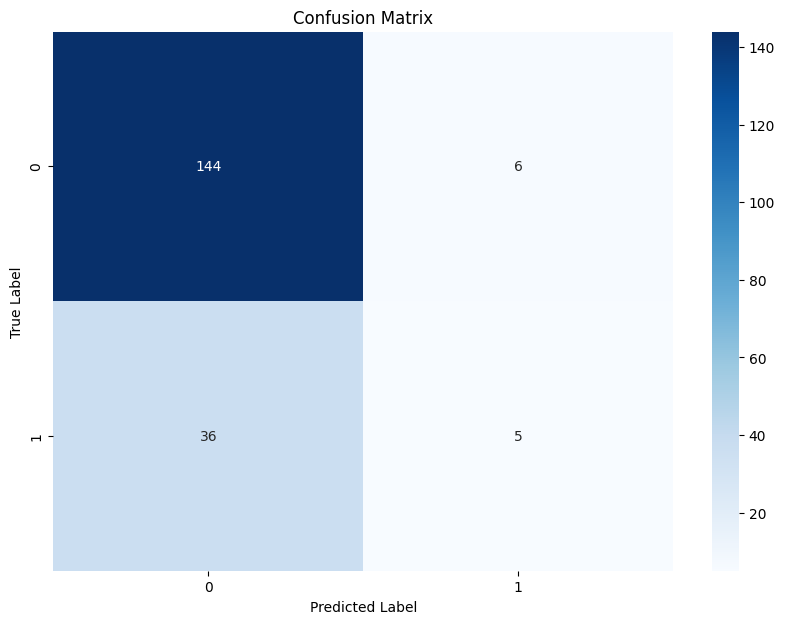

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred)

In [26]:
print(report)

              precision    recall  f1-score   support

           0       0.80      0.99      0.89       150
           1       0.71      0.12      0.21        41

    accuracy                           0.80       191
   macro avg       0.76      0.55      0.55       191
weighted avg       0.79      0.80      0.74       191

